In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `/dh-projects/ag-ishaque/analysis/muellni/Projects/Stereo_seq/publication/julia`


In [2]:
using JupyterFormatter
enable_autoformat();

In [3]:
Threads.nthreads()

16

# Settings & Imports


In [4]:
using ImageTransformations
using ImageShow
using SparseArrays
using Sainsc

In [5]:
stereoseq_file = "../data/StereoSeq/Mouse_brain_Adult_GEM_bin1.tsv.gz";
signature_file = "../StereoSeq_Brain_segmentation_signatures.tsv";
color_file = "../colormap_brain_publication.json";

In [6]:
counts = readstereoseq(stereoseq_file);

In [9]:
counts

GridCounts{String,Int16} (10500, 13950) with 26177 genes

# Signatures & Colors

In [7]:
using CSV
using DataFrames

signatures = CSV.read(signature_file, DataFrame, transpose = true);
celltypes = signatures.Column1;
select!(signatures, Not(:Column1));

# remove gens that are not in dataset
signatures = signatures[:, names(signatures).∈[keys(counts)]];

# KDE


In [8]:
kernel = gaussiankernel(8, 2);
kernel = convert.(Float32, kernel);

In [9]:
total_rna = kde(Matrix(totalrna(counts)), kernel);

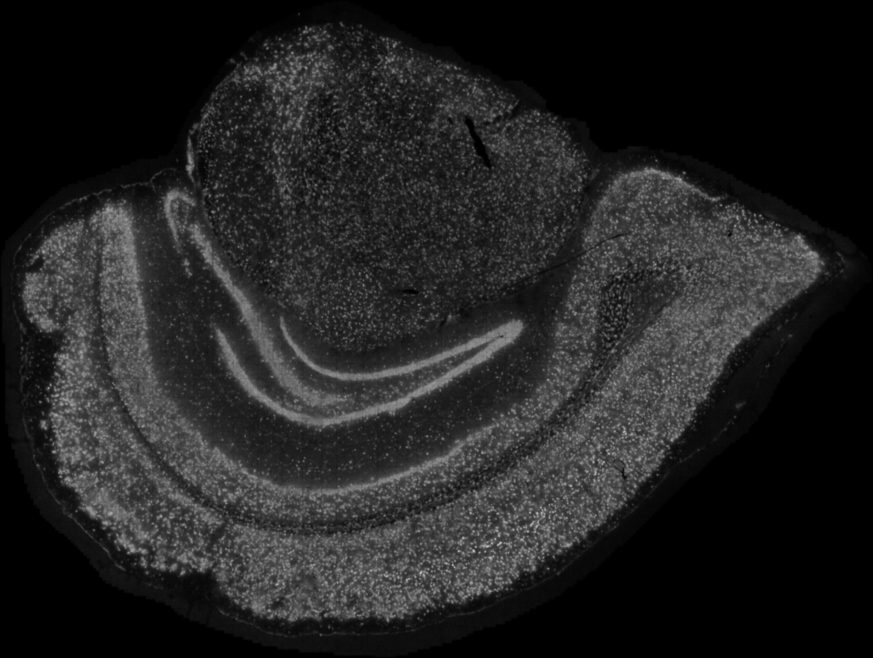

In [10]:
simshow(total_rna)

# Assign celltype


In [11]:
ctmap, cos_sim, assignment =
    assigncelltype(counts, signatures, kernel, celltypes = celltypes, log = true);

# Write to file

In [12]:
using HDF5

fid = h5open("StereoSeq_Brain_results.h5", "w");

In [13]:
fid["total_kde"] = total_rna;

In [14]:
fid["assignment_score"] = assignment;
fid["cosine_similarity"] = cos_sim;

In [15]:
using CategoricalArrays

replace!(ctmap, missing => "missing");

In [16]:
fid["celltype_map"] = ctmap.refs;
fid["celltypes"] = levels(ctmap);

In [17]:
close(fid);